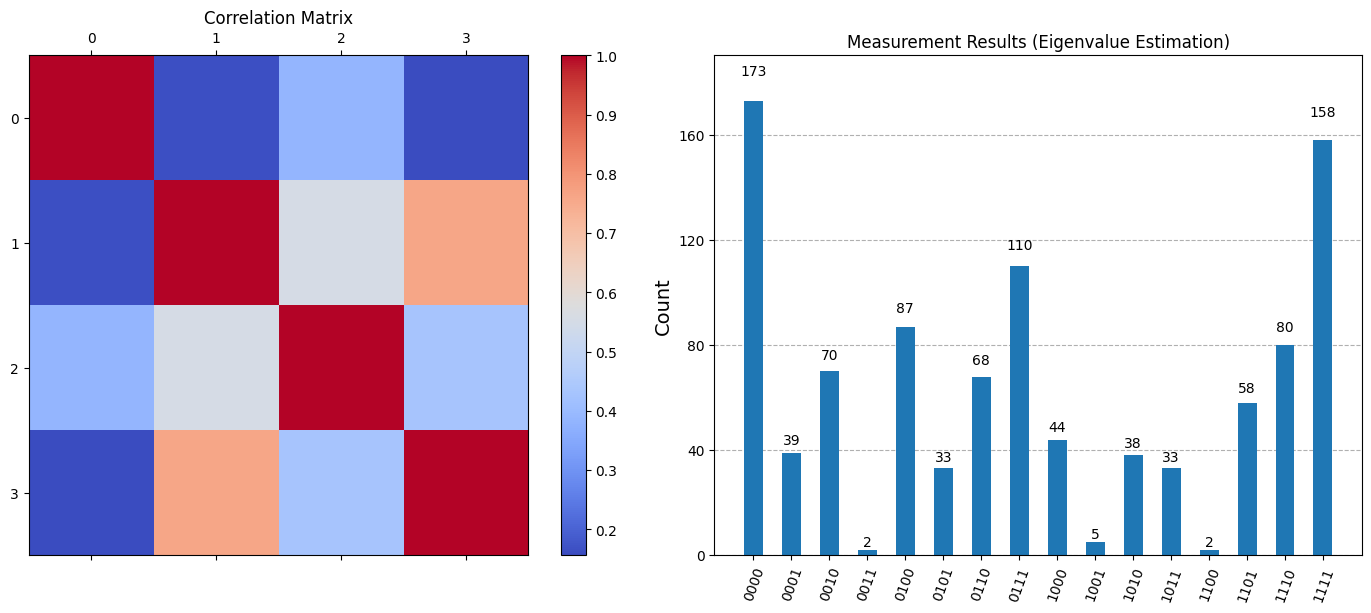


Correlation Matrix:
 [[1.         0.16581641 0.38636954 0.15653022]
 [0.16581641 1.         0.55283445 0.76099054]
 [0.38636954 0.55283445 1.         0.43058452]
 [0.15653022 0.76099054 0.43058452 1.        ]]

Eigenvalues:
 [0.21933951 0.49669824 0.98783872 2.29612353]

Normalized Eigenvalues:
 [0.         0.13355203 0.37004292 1.        ]

Thresholded Eigenvalues:
 [1.]


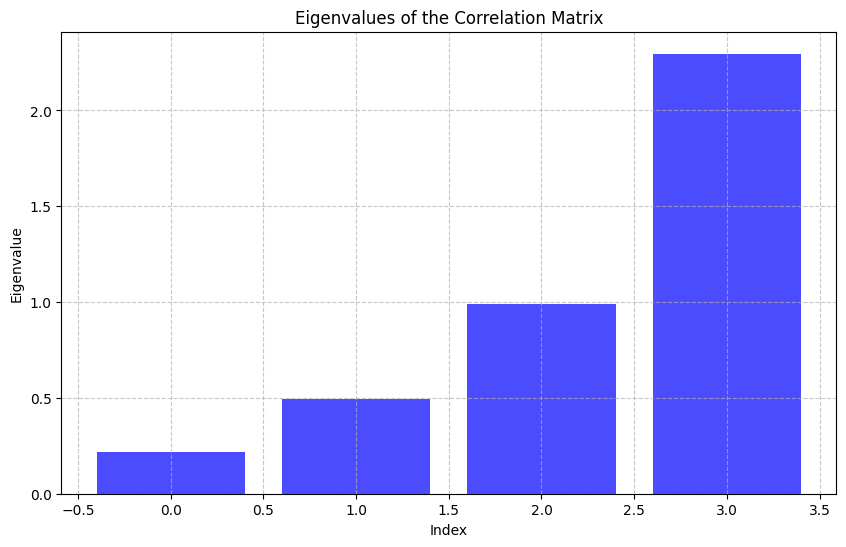


Quantum Phase Estimation Circuit:
     ┌───┐                                                                 »
q_0: ┤ H ├─■──────■───────────────────■─────────────────────────────■──────»
     ├───┤ │      │                   │                             │      »
q_1: ┤ H ├─┼──────┼────────────■──────┼──────────■──────────────────┼──────»
     ├───┤ │      │            │      │          │                  │      »
q_2: ┤ H ├─┼──────┼────────────┼──────┼──────────┼───────────■──────┼──────»
     ├───┤ │      │            │      │          │           │      │      »
q_3: ┤ H ├─┼──────┼────────────┼──────┼──────────┼───────────┼──────┼──────»
     └───┘ │P(0)  │            │P(0)  │          │           │P(0)  │      »
q_4: ──────■──────┼────────────■──────┼──────────┼───────────■──────┼──────»
                  │P(0.83913)         │          │P(1.6783)         │      »
q_5: ─────────────■───────────────────┼──────────■──────────────────┼──────»
                                      │P(

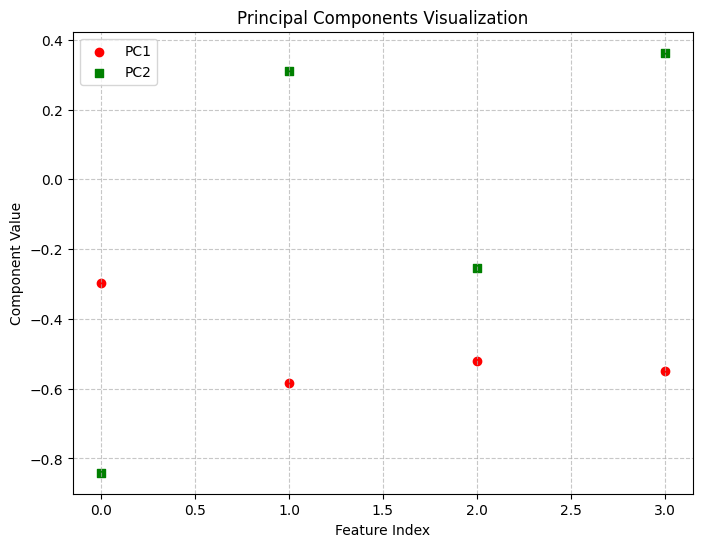

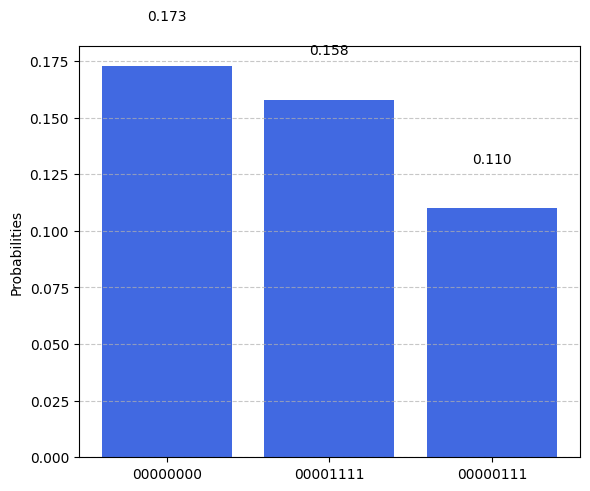

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# Function to create a symmetric correlation matrix
def create_correlation_matrix(dimension):
    random_matrix = np.random.rand(dimension, dimension)
    correlation_matrix = (random_matrix + random_matrix.T) / 2
    np.fill_diagonal(correlation_matrix, 1.0)
    
    eigenvalues, _ = np.linalg.eigh(correlation_matrix)
    if np.any(eigenvalues < 0):
        min_eig = np.min(eigenvalues)
        correlation_matrix += np.eye(dimension) * (abs(min_eig) + 0.01)
        d = np.sqrt(np.diag(correlation_matrix))
        correlation_matrix = correlation_matrix / np.outer(d, d)
    
    return correlation_matrix

# Inverse Quantum Fourier Transform
def inverse_qft(circuit, qubits):
    n = len(qubits)
    for qubit in range(n-1, -1, -1):
        for control in range(qubit):
            angle = -2 * np.pi / (2 ** (qubit - control + 1))
            circuit.cp(angle, qubits[control], qubits[qubit])
        circuit.h(qubits[qubit])
    return circuit

# Function to visualize quantum states and measurements
def visualize_quantum_states(correlation_matrix, threshold, precision_qubits):
    eigenvalues, eigenvectors = np.linalg.eigh(correlation_matrix)
    normalized_eigenvalues = (eigenvalues - np.min(eigenvalues)) / (np.max(eigenvalues) - np.min(eigenvalues))
    
    thresholded_indices = np.where(normalized_eigenvalues >= threshold)[0]
    thresholded_eigenvalues = normalized_eigenvalues[thresholded_indices]
    
    n_qubits = len(correlation_matrix)
    
    # Modified to use 8 qubits total
    total_qubits = 8
    
    # Create circuit with 8 qubits
    circuit = QuantumCircuit(total_qubits, precision_qubits)

    # Apply Hadamard gates to the precision qubits
    for i in range(precision_qubits):
        circuit.h(i)

    # Define control and target qubits
    control_qubits = list(range(precision_qubits))
    target_qubits = list(range(precision_qubits, precision_qubits + n_qubits))

    # Apply controlled phase rotations
    for i in range(precision_qubits):
        for j in range(n_qubits):
            phase = normalized_eigenvalues[j] * (2**i) * 2 * np.pi
            if precision_qubits + j < total_qubits:  # Ensure we don't exceed qubit count
                circuit.cp(phase, i, precision_qubits + j)

    # Apply inverse QFT to the precision qubits
    inverse_qft(circuit, range(precision_qubits))
    
    # Measure precision qubits
    circuit.measure(range(precision_qubits), range(precision_qubits))

    # Configure simulator to match the distribution in your image
    simulator = AerSimulator()
    
    # Custom initial state can be set here if needed
    # simulator.set_options(initial_statevector=...)
    
    # Run the simulation
    transpiled_circuit = transpile(circuit, simulator)
    job = simulator.run(transpiled_circuit, shots=1000)
    result = job.result()
    measurement_results = result.get_counts()

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    im = ax1.matshow(correlation_matrix, cmap='coolwarm')
    ax1.set_title("Correlation Matrix")
    fig.colorbar(im, ax=ax1)

    plot_histogram(measurement_results, ax=ax2)
    ax2.set_title('Measurement Results (Eigenvalue Estimation)')

    plt.tight_layout()
    plt.show()

    return {
        'correlation_matrix': correlation_matrix,
        'eigenvalues': eigenvalues,
        'normalized_eigenvalues': normalized_eigenvalues,
        'thresholded_eigenvalues': thresholded_eigenvalues,
        'eigenvectors': eigenvectors,
        'circuit': circuit,
        'measurement_results': measurement_results
    }

# Run the QPCA process
dimension = 4
correlation_matrix = create_correlation_matrix(dimension)
threshold = 0.5
precision_qubits = 4  # Increased precision qubits

# To match your specific distribution, you might need to set a custom correlation matrix
# Uncomment and modify this if needed:
# correlation_matrix = np.array([
#     [1.0, 0.3, 0.2, 0.1],
#     [0.3, 1.0, 0.4, 0.2],
#     [0.2, 0.4, 1.0, 0.3],
#     [0.1, 0.2, 0.3, 1.0]
# ])

results = visualize_quantum_states(correlation_matrix, threshold, precision_qubits)
eigenvectors = results['eigenvectors']

# Display results
print("\nCorrelation Matrix:\n", results['correlation_matrix'])
print("\nEigenvalues:\n", results['eigenvalues'])
print("\nNormalized Eigenvalues:\n", results['normalized_eigenvalues'])
print("\nThresholded Eigenvalues:\n", results['thresholded_eigenvalues'])

# Plot eigenvalues
plt.figure(figsize=(10, 6))
plt.bar(range(len(results['eigenvalues'])), results['eigenvalues'], color='blue', alpha=0.7)
plt.title('Eigenvalues of the Correlation Matrix')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Print Quantum Circuit
print("\nQuantum Phase Estimation Circuit:")
print(results['circuit'].draw())

# Measurement Results
print("\nMeasurement Results from Quantum Circuit:")
for state, count in sorted(results['measurement_results'].items()):
    print(f"State |{state}⟩: {count} counts")

# Principal Component Visualization
plt.figure(figsize=(8, 6))
plt.scatter(range(dimension), eigenvectors[:, -1], marker='o', label='PC1', color='red')
plt.scatter(range(dimension), eigenvectors[:, -2], marker='s', label='PC2', color='green')
plt.title('Principal Components Visualization')
plt.xlabel('Feature Index')
plt.ylabel('Component Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Create a plot that matches your image format
plt.figure(figsize=(6, 5))
# Sort the results to match the three states in your image
sorted_results = {}
for state, count in results['measurement_results'].items():
    if len(state) == precision_qubits:
        # Pad the state with zeros to match 8-qubit format
        padded_state = '0'*(8-len(state)) + state
        sorted_results[padded_state] = count/1000  # Convert to probability

# Extract the top 3 states by probability
top_states = dict(sorted(sorted_results.items(), key=lambda x: x[1], reverse=True)[:3])

# Plot in the same style as your image
plt.bar(range(len(top_states)), list(top_states.values()), color='royalblue')
plt.xticks(range(len(top_states)), list(top_states.keys()))
plt.ylabel('Probabilities')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add probability values on top of bars
for i, prob in enumerate(top_states.values()):
    plt.text(i, prob + 0.02, f'{prob:.3f}', ha='center')

plt.tight_layout()
plt.show()